# Improving Amazon Transcribe transcriptions using Custom Vocabularies and Amazon Augmented AI (A2I)



This notebook accompanies the blog "Improving Amazon Transcribe transcriptions using Custom Vocabularies and Amazon Augmented AI (A2I)" (TODO: add link)

## Introduction
When transcribing speech containing domain-specific terminologies in fields such as legal, financial, construction, higher education, or engineering, Amazon Transcribe’s [custom vocabularies](https://docs.aws.amazon.com/transcribe/latest/dg/how-vocabulary.html) feature can improve transcription quality. 

To use custom vocabularies with Amazon Transcribe, you need a list of domain-specific terms. If you have a collection of videos or audio files (dataset) that you want transcribed with high accuracy, you can use a portion of your dataset to Amazon Transcribe to assess which terms it has difficulty with (low confidence predictions). You can use Amazon A2I to send these low-confidence predictions directly to a human to review and manually transcribe the terms. This walkthrough will demonstrate how you can process the results obtained from Amazon A2I to quickly to build a custom vocabulary.

In summary, in this walkthrough you will:
* Send a subset of videos to Amazon Transcribe to find terms that are difficult to transcribe.
* Set up a human review workflow using Amazon A2I to send low-confidence predictions to humans for manual review and transcription.
* Create a custom vocabulary using the results obtained from human workers.
* Test Amazon Transcribe on another subset of videos to asses the improvement in transcription quality. 


## Prerequisites

To run this notebook, you can simply execute each cell in order. To understand what's happening, you'll need:

* An S3 bucket you can write to -- please provide its name in BUCKET. The bucket must be in the same region as this SageMaker Notebook instance. You can also change the EXP_NAME to any valid S3 prefix. All the files related to this experiment will be stored in that prefix of your bucket.
* Familiarity with the Amazon A2I.
* Familiarity with Python and numpy.
* Basic familiarity with AWS S3.
* Basic understanding of Amazon Transcribe and custom vocabularies. 
* Basic familiarity with AWS Command Line Interface (CLI) -- ideally, you should have it set up with credentials to access the AWS account you're running this notebook from.

This notebook has only been tested on a SageMaker notebook instance. The runtimes given are approximate. We used an ml.t2.medium instance in our tests. However, you can likely run it on a local instance by first executing the cell below on SageMaker and then copying the role string to your local copy of the notebook.

For more sample notebooks using A2I, visit this [Github repository](https://github.com/aws-samples/amazon-a2i-sample-jupyter-notebooks).

Let's get started!

### Install Latest SDKs

In [ ]:
# First, let's get the latest installations of our dependencies
!pip install --upgrade pip
!pip install boto3 --upgrade
!pip install -U botocore

### Setup

In [2]:
import io
import uuid
import botocore
import boto3
import time
import pprint
import json
import sagemaker
from sagemaker import get_execution_role
from datetime import datetime, timezone

# Amazon SageMaker client
sagemaker = boto3.client('sagemaker')

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

# Amazon S3 (S3) client
s3 = boto3.client('s3')

### Region, Bucket, and Paths
Make sure all your resources are stored in the same region. You'll be using the same bucket for this entire walkthrough.

In [3]:
BUCKET = 'jashuang-sagemaker-5-22'
EXP_NAME = '' # Any valid S3 prefix.
OUTPUT_PATH = f's3://{BUCKET}/a2i-results'

In [7]:
sess = sagemaker.session.Session()
role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name
s3 = boto3.client('s3')
bucket_region = s3.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "Your S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

AttributeError: 'SageMaker' object has no attribute 'session'

### Roles and Permissions

Add the following policies to this role in IAM:
* AmazonAugmentedAIFullAccess
* AmazonTranscribeFullAccess

Or you can add a single policy, which will grant permissions to Amazon A2I and all integrated services (Amazon Rekognition and Amazon Transcribe)
* AmazonAugmentedAIIntegratedAPIAccess

Your execution role has the AmazonSageMakerFullAccess policy attached. This gives Amazon SageMaker permission to access your resources in S3 if the bucket or objects have the word `sagemaker` in the name. If your S3 bucket listed in `BUCKET` does not have sagemaker in the name, you will need to add an S3 policy to your execution role to give your role permissions to access your data objects in S3. The following is an example of an S3 policy:

```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "s3:GetObject"
            ],
            "Resource": [
                "arn:aws:s3:::my_input_bucket/*"
            ]
        },
        {
            "Effect": "Allow",
            "Action": [
                "s3:PutObject"
            ],
            "Resource": [
                "arn:aws:s3:::my_output_bucket/*"
            ]
        }
    ]
}
```


In [8]:
from sagemaker import get_execution_role

ROLE = get_execution_role()
display(ROLE)

# role_name = role.split('/')[-1]
# print(f'Your execution role name: {role_name}')

'arn:aws:iam::688520471316:role/service-role/AmazonSageMaker-ExecutionRole-20200522T134110'

### Upload Sample Video to S3
For this demo, we'll be analyzing an introductory video about SageMaker that's titled "Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive" and features Emily Webber, an ML Specialist at AWS.

TODO: upload the video to a public blog bucket.

## Step 1: Basic Transcription Job
Our first step is to look at the performance of Amazon Transcribe using default parameters and establish a baseline for comparison. Once you have the SageMaker video mp4 file uploaded to an S3 bucket, you can use the transcribe function to start a transcription job. Note that the `vocab_name` parameter will be used later to specify custom vocabularies, and it’s currently defaulted to `None`.

In [44]:
region='us-west-2'
s3 = boto3.client("s3", region)

# You can give the transcription job any name.
# job_name_1 = "AWS-sage-1"

job_names = [
    "AWS-sage-vid-1",
    "AWS-sage-vid-2",
    "AWS-sage-vid-3",
    "AWS-sage-vid-4",
    "AWS-sage-vid-5",
    "AWS-sage-vid-6",
    "AWS-sage-vid-7",
    "AWS-sage-vid-8",
    "AWS-sage-vid-9",
    "AWS-sage-vid-10",
]

# Audio file path
# job_uri_s3 = f"s3://{BUCKET}/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4"

# Path to folder
folder_path = f"s3://{BUCKET}/transcribe-bucket/"

all_videos = [
             'Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4',
             'Built-in Machine Learning Algorithms with Amazon SageMaker - a Deep Dive.mp4',
             'Bring Your Own Custom ML Models with Amazon SageMaker.mp4',
             'Train Your ML Models Accurately with Amazon SageMaker.mp4',
             'Deploy Your ML Models to Production at Scale with Amazon SageMaker.mp4',
             'Tune Your ML Models to the Highest Accuracy with Amazon SageMaker Automatic Model Tuning.mp4',
             'Scale up Training of Your ML Models with Distributed Training on Amazon SageMaker.mp4',
             'Use the Deep Learning Framework of Your Choice with Amazon SageMaker.mp4',
             'Learn to Analyze the Co-Relation in Your Datasets Using Feature Engineering with Amazon SageMake.mp4',
             'Get Scheduled Predictions on Your ML Models with Amazon SageMaker Batch Transform.mp4'
]

insample_video_indices = [0,2]
outsample_video_indices = [1,3]

datetime.now()

datetime.datetime(2020, 6, 15, 16, 42, 43, 251439)

In [31]:
# Here is a transcribe function
def transcribe(job_name, job_uri, out_bucket, format="mp4", vocab_name=None):
    """Transcribe a .wav or .mp4 file to text.
    Args:
        job_name (str): the name of the job that you specify;
                        the output json will be job_name.json
        job_uri (str): input path (in s3) to the file being transcribed
        out_bucket (str): s3 bucket name that you want the output json
                          to be placed in
        format (str): mp4 or wav for input file format;
                      defaults to mp4
        vocab_name (str): name of custom vocabulary used;
                          optional, defaults to None
    """
    
    if format not in ['mp3','mp4','wav','flac']:
        print("Invalid format")
        return

    try:
        transcribe = boto3.client("transcribe")
        print("------" + format)
        if vocab_name is None:
            transcribe.start_transcription_job(
                TranscriptionJobName=job_name,
                Media={"MediaFileUri": job_uri},
                MediaFormat=format,
                LanguageCode="en-US",
                OutputBucketName=out_bucket,
            )
        else:
            transcribe.start_transcription_job(
                TranscriptionJobName=job_name,
                Media={"MediaFileUri": job_uri},
                MediaFormat=format,
                LanguageCode="en-US",
                OutputBucketName=out_bucket,
                Settings={'VocabularyName': vocab_name}
            )
        
        time.sleep(2)
        
        print(transcribe.get_transcription_job(TranscriptionJobName=job_name))
        
#         while True:
#             status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
#             if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
#                 break
#             print("Not ready yet...")
#             time.sleep(5)
#         print(status)

    except Exception as e:
        print(e)

In [35]:
# Start a transcription job
transcribe(job_names[8], folder_path+all_videos[8], BUCKET)

------mp4
{'TranscriptionJob': {'TranscriptionJobName': 'AWS-sage-vid-9', 'TranscriptionJobStatus': 'IN_PROGRESS', 'LanguageCode': 'en-US', 'MediaSampleRateHertz': 44100, 'MediaFormat': 'mp4', 'Media': {'MediaFileUri': 's3://jashuang-sagemaker-5-22/transcribe-bucket/Learn to Analyze the Co-Relation in Your Datasets Using Feature Engineering with Amazon SageMake.mp4'}, 'Transcript': {}, 'StartTime': datetime.datetime(2020, 6, 12, 23, 2, 54, 959000, tzinfo=tzlocal()), 'CreationTime': datetime.datetime(2020, 6, 12, 23, 2, 54, 938000, tzinfo=tzlocal()), 'Settings': {'ChannelIdentification': False, 'ShowAlternatives': False}}, 'ResponseMetadata': {'RequestId': '01aeb419-009d-4903-a314-da966dc46167', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Fri, 12 Jun 2020 23:02:58 GMT', 'x-amzn-requestid': '01aeb419-009d-4903-a314-da966dc46167', 'content-length': '493', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [32]:
for i in range(0,10):
    transcribe(job_names[i], folder_path+all_videos[i], BUCKET)

------mp4
{'TranscriptionJob': {'TranscriptionJobName': 'AWS-sage-vid-1', 'TranscriptionJobStatus': 'IN_PROGRESS', 'LanguageCode': 'en-US', 'MediaSampleRateHertz': 44100, 'MediaFormat': 'mp4', 'Media': {'MediaFileUri': 's3://jashuang-sagemaker-5-22/transcribe-bucket/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4'}, 'Transcript': {}, 'StartTime': datetime.datetime(2020, 6, 12, 23, 0, 39, 114000, tzinfo=tzlocal()), 'CreationTime': datetime.datetime(2020, 6, 12, 23, 0, 39, 91000, tzinfo=tzlocal()), 'Settings': {'ChannelIdentification': False, 'ShowAlternatives': False}}, 'ResponseMetadata': {'RequestId': '5a613cca-5755-434e-9451-a37a5dd47315', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Fri, 12 Jun 2020 23:00:41 GMT', 'x-amzn-requestid': '5a613cca-5755-434e-9451-a37a5dd47315', 'content-length': '465', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}
------mp4
{'TranscriptionJob': {'TranscriptionJobName': 'AWS-sag

### Retrieve and Parse Transcription Results

When the transcription job finishes, the results will be stored in your specified S3 bucket as an output JSON file called “YOUR_JOB_NAME.json.” You can use the following function to retrieve your results, and parse them into sentences with time stamps, confidence scores, and other useful representations.

In [117]:
def get_transcript_text_and_timestamps(bucket_name, file_name):
    """take json file from S3 bucket and returns a tuple of:
       entire transcript, list object of tuples of timestamp and individual sentences
    
    Args:
        bucket_name (str): name of s3 bucket
        file_name (str): name of file
    Returns:
        (
        entire_transcript: str,
        sentences_and_times: [ {start_time (sec) : float,
                                end_time (sec)   : float,
                                sentence         : str,
                                min_confidence   : float (minimum confidence score of that sentence)
                                } ],
        confidences:  [ {start_time (sec) : float,
                         end_time (sec)   : float,
                         content          : str, (single word/phrase)
                         confidence       : float (confidence score of the word/phrase)
                         } ],
        scores: list of confidence scores
        )
    """
    s3_clientobj = s3.get_object(Bucket=bucket_name, Key=file_name)
    s3_clientdata = s3_clientobj["Body"].read().decode("utf-8")

    original = json.loads(s3_clientdata)
    items = original["results"]["items"]
    entire_transcript = original["results"]["transcripts"]

    sentences_and_times = []
    temp_sentence = ""
    temp_start_time = 0
    temp_min_confidence = 1.0
    newSentence = True
    
    confidences = []
    scores = []

    i = 0
    for item in items:
        # always add the word
        if item["type"] == "punctuation":
            temp_sentence = (
                temp_sentence.strip() + item["alternatives"][0]["content"] + " "
            )
        else:
            temp_sentence = temp_sentence + item["alternatives"][0]["content"] + " "
            temp_min_confidence = min(temp_min_confidence,
                                      float(item["alternatives"][0]["confidence"]))
            confidences.append({"start_time": float(item["start_time"]),
                                "end_time": float(item["end_time"]),
                                "content": item["alternatives"][0]["content"],
                                "confidence": float(item["alternatives"][0]["confidence"])
                               })
            scores.append(float(item["alternatives"][0]["confidence"]))

        # if this is a new sentence, and it starts with a word, save the time
        if newSentence == True:
            if item["type"] == "pronunciation":
                temp_start_time = float(item["start_time"])
            newSentence = False
        # else, keep going until you hit a punctuation
        else:
            if (
                item["type"] == "punctuation"
                and item["alternatives"][0]["content"] != ","
            ):
                # end time of sentence is end_time of previous word
                end_time = items[i-1]["end_time"] if i-1 >= 0 else items[0]["end_time"]
                sentences_and_times.append(
                    {"start_time": temp_start_time,
                     "end_time": end_time,
                     "sentence": temp_sentence.strip(),
                     "min_confidence": temp_min_confidence
                    }
                )
                # reset the temp sentence and relevant variables
                newSentence = True
                temp_sentence = ""
                temp_min_confidence = 1.0
                
        i = i + 1
        
    sentences_and_times.append(
                    {"start_time": temp_start_time,
                     "end_time": confidences_1[-1]["end_time"],
                     "sentence": temp_sentence.strip(),
                     "min_confidence": temp_min_confidence
                    }
                )
    return entire_transcript, sentences_and_times, confidences, scores

In [118]:
entire_transcript_1, sentences_and_times_1, confidences_1, scores_1 = get_transcript_text_and_timestamps("jashuang-sagemaker-5-22","AWS-sage-vid-2.json")

print(sentences_and_times_1[-1])

# file0 = open("ground_truth_4.txt","w") 
# for tup in sentences_and_times_1:
#     file0.write(tup['sentence'] + "\n") 
# file0.close()

{'start_time': 926.48, 'end_time': 930.95, 'sentence': 'Thank you for your time and go ahead and check out our get help site at Amazon Sagemaker examples', 'min_confidence': 0.5393}


In [38]:
all_entire_transcript = []
all_sentences_and_times = []
all_confidences = []
all_scores = []
for i in range(0,10):
    entire_transcript_1, sentences_and_times_1, confidences_1, scores_1 = get_transcript_text_and_timestamps("jashuang-sagemaker-5-22",job_names[i]+".json")
    all_entire_transcript.append(entire_transcript_1)
    all_sentences_and_times.append(sentences_and_times_1)
    all_confidences.append(confidences_1)
    all_scores.append(scores_1)

In [39]:
# Sanity check!
print(all_sentences_and_times[0][0])

{'start_time': 0.54, 'end_time': '1.03', 'sentence': 'Hi.', 'min_confidence': 1.0}


In [98]:
# all_scores[0]

In [99]:
flat_scores_list = all_scores[0] + all_scores[2] #[item for sublist in all_scores[0,2] for item in sublist]

### Save the first transcript to a txt file
Let's save the full transcript, as we'll be using this later for comparisons.

In [ ]:
file0 = open("originaltranscript.txt","w") 
for tup in sentences_and_times_1:
    file0.write(tup['sentence'] + "\n") 
file0.close()

### Histogram of confidence scores
Let’s take a look at the distribution of confidence scores.

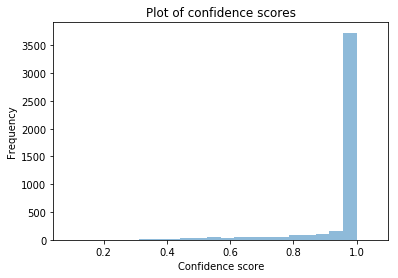

In [100]:
from matplotlib import pyplot as plt

plt.xlim([min(flat_scores_list)-0.1, max(flat_scores_list)+0.1])
plt.hist(flat_scores_list, bins=20, alpha=0.5)
plt.title('Plot of confidence scores')
plt.xlabel('Confidence score')
plt.ylabel('Frequency')

plt.show()

### Histogram of low confidence scores
Let’s filter out the high confidence scores to take a closer look at the lower ones.

In [106]:
threshold = 0.5
all_bad_scores = [i for i in flat_scores_list if i < threshold]
len(all_bad_scores)

77

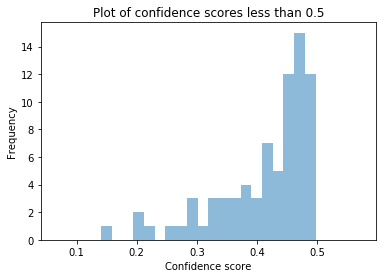

In [107]:
plt.xlim([min(all_bad_scores)-0.1, max(all_bad_scores)+0.1])
plt.hist(all_bad_scores, bins=20, alpha=0.5)
plt.title('Plot of confidence scores less than ' + str(threshold))
plt.xlabel('Confidence score')
plt.ylabel('Frequency')

plt.show()

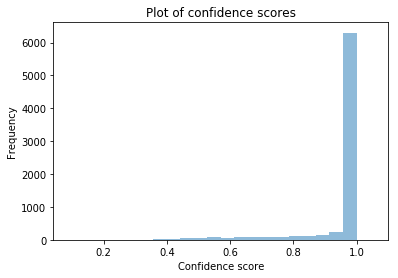

In [89]:
# from matplotlib import pyplot as plt

# plt.xlim([min(flat_scores_list)-0.1, max(flat_scores_list)+0.1])
# plt.hist(flat_scores_list, bins=20, alpha=0.5)
# plt.title('Plot of confidence scores')
# plt.xlabel('Confidence score')
# plt.ylabel('Frequency')

# plt.show()

114

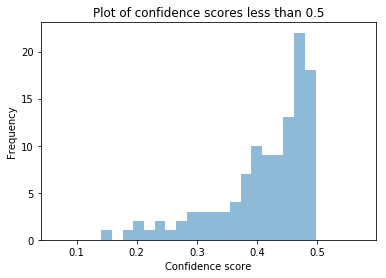

We can see that there is a nontrivial number of words classified with low confidence. As we’ll see later, technical terms are more often mis-transcribed, so it’s important that we correct those mistakes.

## Step 2: Human Review Workflow with A2I

Our next step is create a human review workflow that sends low confidence scores to human reviewers and then retrieves the corrected transcription they provide. This section contains the following steps:

1. Create a work task template that will be displayed to workers for every task. The template will be rendered with input data you provide, instructions to workers, and interactive tools to help workers complete your tasks.
2. Create a human review workflow, also called a flow definition. You use the flow definition to configure details about your human workforce and the human tasks they are assigned.
3. Create a human loop to start the human review workflow, sending data for human review as needed. In this example, you use a custom task type and start human loop tasks using the [Amazon A2I Runtime API](https://docs.aws.amazon.com/augmented-ai/2019-11-07/APIReference/Welcome.html). Each time StartHumanLoop is called, a task is sent to human reviewers.

### Workteam or Workforce


A workforce is the group of workers that you have selected to label your dataset. You can choose either the Amazon Mechanical Turk workforce, a vendor-managed workforce, or you can create your own private workforce for human reviews. Whichever workforce type you choose, Amazon Augmented AI takes care of sending tasks to workers.

When you use a private workforce, you also create work teams, a group of workers from your workforce that are assigned to Amazon Augmented AI human review tasks. You can have multiple work teams and can assign one or more work teams to each job.

To create your Workteam, visit the instructions [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-management.html).

After you have created your workteam, replace YOUR_WORKTEAM_ARN below


In [71]:
WORKTEAM_ARN= "arn:aws:sagemaker:us-west-2:688520471316:workteam/private-crowd/jashuang-test-workforce"

### Clients
Let's setup the rest of our clients.

In [66]:
import io
import json
import uuid
import time
import boto3
import botocore

# Amazon SageMaker client
sagemaker = boto3.client('sagemaker', region)

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

s3 = boto3.client('s3', region)

## Create Control Plane Resources
Now let's create the resources we'll need to build our human review workflow.

### Create Human Task UI

Amazon A2I uses Liquid, an open-source template language that can be used to “inject” data dynamically into HTML files.

In this walkthrough, we want for each task to enable a human reviewer to watch a section of the video and transcribe the speech they hear. The HTML template consists of three main parts:

1. A video player with a replay button that only allows the reviewer to play the specific subsection
2. A form for the reviewer to type and submit what they hear
3. Logic written in JavaScript to give the replay button its intended functionality

For over 60 other pre-built UIs, check out this [repository](https://github.com/aws-samples/amazon-a2i-sample-task-uis).

Here’s the template you’ll be using:


In [67]:
template = r"""
<head>
    <style>
        h1 {
            color: black;
            font-family: verdana;
            font-size: 150%;
        }
    </style>
</head>
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
    <video id="this_vid">
        <source src="{{ task.input.audioPath | grant_read_access }}"
            type="audio/mp4">
        Your browser does not support the audio element.
    </video>
    <br />
    <br />
    <crowd-button onclick="onClick(); return false;"><h1> Click to play video section!</h1></crowd-button>
    <br />
    Video title: <strong>{{ task.input.video_title }}</strong>
    <br />

    <h3>Instructions</h3>
    <p>Transcribe the audio clip </p>
    <p>Ignore "umms", "hmms", "uhs" and other non-textual phrases. </p>
    <p>The original transcript is <strong>"{{ task.input.original_words }}"</strong>. If the text matches the audio, please retype the same transcription.</p>
    <p>Click the space below to start typing.</p>
    <crowd-text-area name="transcription" rows="2" label="Your transcription" placeholder="Please enter the transcribed text."></crowd-text-area>

    <full-instructions header="Transcription Instructions">
        <h2>Instructions</h2>
        <p>Click the play button and listen carefully to the audio clip. Type what you hear in the box
            below. Replay the clip by clicking the button again, as many times as needed.</p>
    </full-instructions>

</crowd-form>

<script>
    var video = document.getElementById('this_vid');
    video.onloadedmetadata = function() {
        video.currentTime = {{ task.input.start_time }};
    };
    function onClick() {
        video.pause();
        video.currentTime = {{ task.input.start_time }};
        video.play();
        video.ontimeupdate = function () {
            if (video.currentTime >= {{ task.input.end_time }}) {
                video.pause()
            }
        }
    }
</script>
"""

#t={{ task.input.start_time }},{{ task.input.end_time }}

def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

The `{{ task.input.audioPath | grant_read_access }}` field allows you to grant access to and display a video using a path to the video’s location in an S3 bucket. To prevent the reviewer from navigating to irrelevant sections of the video, the `controls` parameter is omitted from the video tag and a single replay button is included to control which section can be replayed.

Below the video player, the `<crowd-text-area>` HTML tag creates a submission form that your reviewer will use to type and submit.

At the end of the HTML snippet, the `<script>` tag contains the logic for the replay button. The `{{ task.input.start_time }}` and `{{ task.input.end_time }}` fields allow you to inject the start and end times of the video subsection you want transcribed for the current task.

Now let's create a Human Task UI resource.

In [68]:
# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'ui-transcribe-' + str(uuid.uuid4()) 

# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

arn:aws:sagemaker:us-west-2:688520471316:human-task-ui/ui-transcribe-2fd60ba5-f77b-44bd-895a-d8cfea1dab8d


### Flow Definition

In this section, we're going to create a flow definition definition. Flow Definitions allow us to specify:

* The workforce that your tasks will be sent to.
* The instructions that your workforce will receive. This is called a worker task template.
* The configuration of your worker tasks, including the number of workers that receive a task and time limits to complete tasks.
* Where your output data will be stored.

This demo is going to use the API, but you can optionally create this workflow definition in the console as well.

For more details and instructions, see [here](https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html).


In [84]:
# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = 'fd-transcribe-demo-' + str(uuid.uuid4()) 

create_workflow_definition_response = sagemaker.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= ROLE,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Identify the word(s) spoken in the provided audio clip",
            "TaskTitle": "Determine Words/Phrases of Audio Clip" + str(datetime.now())
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [85]:
# Describe flow definition - status should be active
for x in range(60):
    describeFlowDefinitionResponse = sagemaker.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Initializing
Active
Flow Definition is active


## Human Loops
### Sending sequences of words/phrases of low confidence for review
After setting up our Flow Definition, we're ready to use Amazon Transcribe and initiate human loops. While iterating through the list of transcribed words and their confidence scores, we create a HumanLoop task whenever the confidence score is below some threshold, `CONFIDENCE_SCORE_THRESHOLD`.

An important thing to consider is how do we deal with a low-confidence word that is part of a phrase that was also mis-transcribed? To handle these cases, let’s write a function that gets the sequence of words centered about a given index, and the sequence's starting and ending timestamps:

In [74]:
# Use this function to get the words near a word with poor confidence,
# since it is possible that the transcription also mis-transcribed nearby words/phrases
def get_word_neighbors(words, index):
    """
    gets the words transcribe found at most 3 away from the input index
    Returns:
        list: words at most 3 away from the input index
        int: starting time of the first word in the list
        int: ending time of the last word in the list
    """
    i = max(0, index - 3)
    j = min(len(words) - 1, index + 3)
    return words[i: j + 1], words[i]["start_time"], words[j]["end_time"]

Then, for every word we encounter with low confidence, we send its associated sequence of neighboring words for human review:

In [ ]:
# variable names for convenience
# all_entire_transcript = []
# all_sentences_and_times = []
# all_confidences = []
# all_scores = []
# job_names = [
#     "AWS-sage-vid-1",
#     "AWS-sage-vid-2",
#     "AWS-sage-vid-3",
#     "AWS-sage-vid-4",
#     "AWS-sage-vid-5",
#     "AWS-sage-vid-6",
#     "AWS-sage-vid-7",
#     "AWS-sage-vid-8",
#     "AWS-sage-vid-9",
#     "AWS-sage-vid-10",
# ]

# # Audio file path
# # job_uri_s3 = f"s3://{BUCKET}/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4"

# # Path to folder
# folder_path = f"s3://{BUCKET}/transcribe-bucket/"

# all_videos = [
#              'Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4',
#              'Built-in Machine Learning Algorithms with Amazon SageMaker - a Deep Dive.mp4',
#              'Bring Your Own Custom ML Models with Amazon SageMaker.mp4',
#              'Train Your ML Models Accurately with Amazon SageMaker.mp4',
#              'Deploy Your ML Models to Production at Scale with Amazon SageMaker.mp4',
#              'Tune Your ML Models to the Highest Accuracy with Amazon SageMaker Automatic Model Tuning.mp4',
#              'Scale up Training of Your ML Models with Distributed Training on Amazon SageMaker.mp4',
#              'Use the Deep Learning Framework of Your Choice with Amazon SageMaker.mp4',
#              'Learn to Analyze the Co-Relation in Your Datasets Using Feature Engineering with Amazon SageMake.mp4',
#              'Get Scheduled Predictions on Your ML Models with Amazon SageMaker Batch Transform.mp4'
# ]

In [63]:
# all_entire_transcript[0]

In [86]:
# Sample data, human loop started
human_loops_started = []
CONFIDENCE_SCORE_THRESHOLD = .5

count = 0
for index in training_video_indices:
    this_uri = folder_path+all_videos[index]
    this_confidences = all_confidences[index]
    
    print("========= " + all_videos[index] + " =========")
    
    i = 0
    for obj in this_confidences:
        word = obj["content"]
        neighbors, start_time, end_time = get_word_neighbors(this_confidences, i)

        # Our condition for when we want to engage a human for review
        if (obj["confidence"] < CONFIDENCE_SCORE_THRESHOLD):

            # get the original sequence of words
            sequence = ""
            for block in neighbors:
                sequence += block['content'] + " "

            humanLoopName = str(uuid.uuid4())
            # "initialValue": word,
            inputContent = {
                "audioPath": this_uri,
                "start_time": start_time,
                "end_time": end_time,
                "original_words": sequence,
                "video_title": all_videos[index]
            }
            start_loop_response = a2i.start_human_loop(
                HumanLoopName=humanLoopName,
                FlowDefinitionArn=flowDefinitionArn,
                HumanLoopInput={
                    "InputContent": json.dumps(inputContent)
                }
            )
            human_loops_started.append(humanLoopName)
#             print(f'Confidence score of {obj["confidence"]} is less than the threshold of {CONFIDENCE_SCORE_THRESHOLD}')
#             print(f'Starting human loop with name: {humanLoopName}')
#             print(f'Sending words from times {start_time} to {end_time} to review')
            print(f'The original transcription is ""{sequence}"" \n')
            
            count = count + 1
    #     else:
    # #         print(f'SentimentScore of {obj["confidence"]} is above threshold of {CONFIDENCE_SCORE_THRESHOLD}')
    # #         print('No human loop created. \n')

        i=i+1

print(f'Number of tasks sent to review: {count}')

========= Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4 =========
The original transcription is ""talk about insolence Age maker Comes on "" 

The original transcription is ""insolence Age maker Comes on Stage Maker "" 

The original transcription is ""notebook instances on stage maker it all "" 

The original transcription is ""show up Under are easy to console "" 

The original transcription is ""easy to instance T is the tiny "" 

The original transcription is ""And more cores see is compute optimized "" 

The original transcription is ""on your easy to instance Also you "" 

The original transcription is ""every version of Annecy two instance is "" 

The original transcription is ""want to hold onto our code And "" 

The original transcription is ""encrypted properly including root volume access to "" 

The original transcription is ""notebook instance to our vpc so that "" 

The original transcription is ""that came out a new instance Siri's "" 

The ori

Let's also save the name of each human loop, in case we need to retrieve them later after shutting down this notebook instance.

In [70]:
file_hl = open("human_loops_names.txt","w") 
for name in human_loops_started:
    file_hl.write(name + "\n") 
file_hl.close()

### Check Status of Human Loop

In [77]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)

HumanLoop Name: cc4c36ba-c9b5-49f9-ab62-347aaaa7cdc5
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-5f5e918f-7822-4b48-930f-79d248e5fdab/2020/06/15/21/38/37/cc4c36ba-c9b5-49f9-ab62-347aaaa7cdc5/output.json'}


HumanLoop Name: 307b3256-5f4b-46c3-ae66-ff9b4d280780
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-5f5e918f-7822-4b48-930f-79d248e5fdab/2020/06/15/21/38/38/307b3256-5f4b-46c3-ae66-ff9b4d280780/output.json'}


HumanLoop Name: 29babf7e-ec87-4d9e-a651-fbcbc698b903
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-5f5e918f-7822-4b48-930f-79d248e5fdab/2020/06/15/21/38/38/29babf7e-ec87-4d9e-a651-fbcbc698b903/output.json'}


HumanLoop Name: 0a5ec3e8-e3a1-4d45-97a3-aaf0ff1f933e
HumanLoop Status: InProgress
HumanLoop Output Dest

### Wait For Workers to Complete Task
We display the link to the private worker portal here for convenience.

In [78]:
# Wait For Workers to Complete Task
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!
https://v3t960yxw8.labeling.us-west-2.sagemaker.aws


### Check Status of Human Loop Again

In [46]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)


HumanLoop Name: 0ca4a2c1-858b-4dcf-882b-1c84dad5217f
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-21d6e7b4-9540-4180-ae1b-b7010384f24c/2020/06/04/17/39/49/0ca4a2c1-858b-4dcf-882b-1c84dad5217f/output.json'}


HumanLoop Name: e6d41808-0b59-46de-8467-a474ae67fd98
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-21d6e7b4-9540-4180-ae1b-b7010384f24c/2020/06/04/17/39/49/e6d41808-0b59-46de-8467-a474ae67fd98/output.json'}


HumanLoop Name: c020e21e-cc2a-4d36-8fb6-e6fd7193dc87
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-21d6e7b4-9540-4180-ae1b-b7010384f24c/2020/06/04/17/39/49/c020e21e-cc2a-4d36-8fb6-e6fd7193dc87/output.json'}


HumanLoop Name: 8eba603b-8257-4fd9-9c35-d6af84b5bc7b
HumanLoop Status: Completed
HumanLoop Output Destin

### View Task Results

Once work is completed, Amazon A2I stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 `OUTPUT_PATH` when all work is completed.

In [47]:
import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    pp.pprint(json_output)
    print('\n')

{   'flowDefinitionArn': 'arn:aws:sagemaker:us-west-2:688520471316:flow-definition/fd-transcribe-demo-21d6e7b4-9540-4180-ae1b-b7010384f24c',
    'humanAnswers': [   {   'answerContent': {   'transcription': 'every '
                                                                  'version of '
                                                                  'an ec2 '
                                                                  'instance '
                                                                  'is'},
                            'submissionTime': '2020-06-04T22:05:56.066Z',
                            'workerId': '65bf0cafa9867643',
                            'workerMetadata': {   'identityData': {   'identityProviderType': 'Cognito',
                                                                      'issuer': 'https://cognito-idp.us-west-2.amazonaws.com/us-west-2_rDB2Sn2uV',
                                                                      'sub': 'a56c8c5c-db1e

## Step 3: Custom vocabularies using A2I results

Using the corrected transcriptions from our human reviewers, let’s parse through these results to identify the domain-specific terms that we want to add to a custom vocabulary. 

### Retrieve A2I results
To get the technical terms identified by human review, we first accumulate all human-reviewed words into a list.

In [48]:
corrected_words = []

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    
    # add the human-reviewed answers split by spaces
    corrected_words += json_output['humanAnswers'][0]['answerContent']['transcription'].split(" ")

In [49]:
print(corrected_words)

['every', 'version', 'of', 'an', 'ec2', 'instance', 'is', 'distributing', 'data', 'sets', 'what', 'about', 'pipe', 'mode', 'but', 'definitely', 'use', 'Lambda', 'to', 'turn', 'your']


### Filtering out common English words
Now, we want to parse through these words and look for “uncommon” English words. An easy way to do this is to use a large English corpus and verify whether each of our human-reviewed words exists in this corpus:

In [43]:
# Create dictionary of English words
# Note that this corpus of words is not 100% exhaustive
import nltk
nltk.download('words')
from nltk.corpus import words
my_dict=set(words.words()) 

[nltk_data] Downloading package words to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [41]:
# Function for removing contractions
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
def remove_contractions(word_list):
    return [word for word in word_list if word not in contractions]

### View Technical/Uncommon Words
After removing contractions, human-reviewed words that are not in the English language corpus are likely to be the technical terms we are looking for.

In [50]:
for word in remove_contractions(corrected_words):
    if word not in my_dict:
        print(word)

ec2
distributing
sets
Lambda


### Create Custom Vocabulary
Using the technical terms identified above, we manually created a custom vocabulary of those terms that we want Transcribe to be able to recognize. A custom vocabulary table enables options to tell Amazon Transcribe how each technical term is pronounced and how it should be displayed.

More details on how to form a custom vocabulary table can be found [here](https://docs.aws.amazon.com/transcribe/latest/dg/how-vocabulary.html#create-vocabulary-table).

Note that as you process additional videos on the same topic, you can keep updating this list, and the number of new technical terms you'll have to add will likely decrease each time you get a new video.

TODO: update this list for comprehensive vocab after doing entire video analysis.

In [93]:
finalized_words=[['Phrase','IPA','SoundsLike','DisplayAs'], # This top line denote the column headers of the text file.
                 ['E.C.-Two','','ee-see-too','EC2'],
                 ['E.C.-Two-instance','','ee-see-too-in-stunce','EC2 instance'],
                 ['lambda','','lam-duh','Lambda'],
                 ['S.D.K.','','ess-dee-kay','SDK'],
                 ['boto-three','','boe-toe-three','Boto3'],
                 ['S.-Three','','ess-three','S3'],
                 ['github','','git-hub','Github'],
                 ['sagemaker','','sage-may-ker','SageMaker'],
                 ['E.B.S.','','ee-bee-ess','EBS'],
                 ['G.P.U.','','gee-pee-you','GPU'],
                 ['git-repository','','git-ree-paw-zih-tor-ee','Git repository'],
                 ['jupyter','','joo-pih-ter','Jupyter'],
                 ['kernel','','ker-null','kernel'],
                 ['config','','con-fig','config'],
                 ['configs','','con-figs','configs'],
                 ['D.B.-pedia','','dee-bee-pee-dee-yuh','dbpedia'],
                 ['git-clone','','','git clone'],
                 ['notebook-instance','','','notebook instance'],
                 ['V.P.C.','','','VPC'],
                ]

### Write the Table to a Txt File

In [ ]:
custom_vocab_file_name = "customvocab3.txt"
file1 = open(custom_vocab_file,"w")
template = '{}\t{}\t{}\t{}\n'
for line in finalized_words:
    file1.write(template.format(line[0],
                                line[1],
                                line[2],
                                line[3])
               )
file1.close()

### Upload Custom Vocabulary File to S3

In [ ]:
import logging
import boto3
from botocore.exceptions import ClientError


def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [ ]:
upload_file(custom_vocab_file_name, BUCKET)

### Create the Custom Vocabulary
After saving your custom vocabulary table to a text file and uploading it to an S3 bucket, create your custom vocabulary with a specified name so that Amazon Transcribe can use it.

In [ ]:
vocab_improved='aws-sagemaker-vocab-4'

In [ ]:
transcribe = boto3.client("transcribe")
response = transcribe.create_vocabulary(
    VocabularyName=vocab_improved,
    LanguageCode='en-US',
    VocabularyFileUri='s3://' + BUCKET + '/' + custom_vocab_file_name
)

In [ ]:
pp.pprint(response)

In [ ]:
# Get the status of the vocab you created again (must wait until its VocabularyState is READY)
response2 = transcribe.get_vocabulary(
    VocabularyName=vocab_improved
)
pp.pprint(response2)

## Step 4: Improved Transcription using your Custom Vocabulary

### Re-transcribe using the Custom Vocabulary

In [ ]:
# Create another job name
job_name_2='AWS-sage-improved-1'

In [ ]:
# Start another transcription job using your custom vocabulary.
transcribe(job_name_2, job_uri_s3, BUCKET, vocab_name=vocab_improved)

In [ ]:
entire_transcript_2,sentences_and_times_2, confidences_2, scores_2 = get_transcript_text_and_timestamps(BUCKET,
                                                                                                      job_name_2+".json")
                                                                                                       

### Write the Improved Transcript to Txt File

In [ ]:
# save the improved transcript
file4 = open("improvedtranscript_2.txt","w") 
for tup in sentences_and_times_2:
    file4.write(tup['sentence'] + "\n") 
file4.close()

By now, we have two transcript versions — one using default parameters and one using our custom vocabulary. To compare these two transcripts, the last thing we need is a “ground truth” transcript, i.e., an answer key. For this demo, we’ve created a ground truth transcript for the first 5 minutes of the SageMaker video, which you can find in the Github repository.

### Calculating Word Error Rate (WER)
The most common metric for speech recognition accuracy is called word error rate (WER), which can be roughly defined to be the proportion of transcription errors relative to the number of words that were actually said. More details can be found here (https://en.wikipedia.org/wiki/Word_error_rate).

We'll be using a lightweight open-source Python library called JiWER for calculating WER between transcripts.

For more details, see the open-source [description](https://pypi.org/project/jiwer/).

In [ ]:
!pip install jiwer

In [ ]:
from jiwer import wer
import jiwer

In [ ]:
# Small example
ground_truth = "hello world"
hypothesis = "hello duck"

In [ ]:
wer(ground_truth, hypothesis)

In [ ]:
# Create a transformation function to preprocess transcript
transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemovePunctuation(),
    jiwer.RemoveWhiteSpace(replace_by_space=True),
    jiwer.SentencesToListOfWords(),
    jiwer.SentencesToListOfWords(word_delimiter=" "),
    jiwer.RemoveEmptyStrings()
]) 

### Get the original transcript (before applying the custom vocabulary)

In [ ]:
hypothesis_2_original = ""
f3 = open("originaltranscript.txt", "r")
for line in f3:
    if line.strip() == "--STOP--":
        break
    hypothesis_2_original += (line.strip() + " ")
f3.close()

### Get the new transcript (after applying the custom vocabulary)

In [ ]:
hypothesis_2 = ""
f2 = open("improvedtranscript_2.txt", "r")
for line in f2:
    if line.strip() == "--STOP--":
        break
    hypothesis_2 += (line.strip() + " ")
f2.close()

### Get the "Ground Truth" transcript

In [ ]:
ground_truth_2 = ""
f1 = open("ground_truth.txt", "r")
for line in f1:
    if line.strip() == "--STOP--":
        break
    ground_truth_2 += (line.strip() + " ")
f1.close()

### Compute Baseline Accuracy

In [ ]:
jiwer.wer(
    ground_truth_2, 
    hypothesis_2_original, 
    truth_transform=transformation, 
    hypothesis_transform=transformation
)

### Compute New Accuracy

In [ ]:
jiwer.wer(
    ground_truth_2, 
    hypothesis_2, 
    truth_transform=transformation, 
    hypothesis_transform=transformation
)

## Discussion

For the first 5 minutes of the SageMaker video we used for this demo, the WER decreased from 9.4% to 3.1%, or over 60% improvement.

At second glance, the initial WER of 9.4% might already feel sufficiently low — less than 1 in 10 words are mis-transcribed! However, this rate can be misleading, since domain-specific terms are often the least common words spoken (relative to frequent words like “to,” “and,” “I” etc.) but the most commonly mis-transcribed. For applications like search engine optimization (SEO), it could be critical that these technical terms are transcribed correctly. Let’s take a look at how our custom vocabulary impacted the transcription of several important technical terms:

TODO: complete full analysis on entire video to update the above metrics and the chart below

| Technical Term | Ground Truth mentions | Default Transcript mentions | Custom Vocab Transcript mentions |
|----------------|-----------------------|-----------------------------|----------------------------------|
| SageMaker      | 7                     | 1 (14%)                     | 7 (100%)                         |
| EC2            | 12                    | 0 (0%)                      | 12 (100%)                        |
| EBS            | 7                     | 3 (43%)                     | 6 (86%)                          |

Now it does look like custom vocabularies were worth the effort!

### Cleaning up
To avoid incurring unnecessary charges, delete resources when not in use.

## Recap

In this post, we walked through an example of how you can improve transcripts from Amazon Transcribe using custom vocabularies and an Amazon A2I human review workflow. This allows you to quickly identify domain-specific terms using your own private workforce and review workflows, and use these terms to build a custom vocabulary so that future mentions of term are transcribed with greater accuracy, at scale. Transcribing key technical terms correctly can be important for doing SEO, enabling highly specific textual queries, and grouping large quantities of video or audio files by technical terms.

The full proof-of-concept Jupyter notebook can be found at this Github repository. Check out other blog posts covering integrations of Amazon A2I, such as [Using Amazon Textract with Amazon Augmented AI for processing critical documents](https://aws.amazon.com/blogs/machine-learning/using-amazon-textract-with-amazon-augmented-ai-for-processing-critical-documents/) and [Designing human review workflows with Amazon Translate and Amazon Augmented AI](https://aws.amazon.com/blogs/machine-learning/designing-human-review-workflows-with-amazon-translate-and-amazon-augmented-ai/).


## The End!
For a more detailed discussion with visuals, check out the accompanying blog post.